In [34]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools

# Open image

In [35]:
image = []
slice_position = []
for dicom in tqdm.tqdm(sorted(glob.glob('../experiment_files/images/Patient_10/SE0001/*.dcm'))):
    dcm = pydicom.dcmread(dicom)
    image.append(dcm.pixel_array)
    slice_position.append(dcm.SliceLocation)
    
image = np.stack(image, axis=-1)
voxel_size = np.array([
    float(dcm.PixelSpacing[0]),
    float(dcm.PixelSpacing[1]),
    np.abs((float(slice_position[0]) - float(slice_position[-1])) / (len(slice_position) - 1))
])/1000

100%|██████████| 128/128 [00:00<00:00, 1077.73it/s]


In [36]:
image.shape

(512, 512, 128)

In [37]:
voxel_size

array([0.00035352, 0.00035352, 0.001     ])

In [38]:
def transfer_function(image, method='first'):
    if method == 'first':
        density = np.zeros_like(image)
        density = np.where(image < -365, 1.0491 + 1.0526e-3 * image, density)
        density = np.where(image >= -365, 1.0053 + 8.921e-4 * image, density)
        density = np.where(image >= 255, 1.0610 + 6.813e-4 * image, density)
        density = density * 1000 # Conversion from g/cm^3 to kg/m^3
    elif method == 'second':
        density = np.zeros_like(image)
        density = np.where(image < 148, 1.0168 + 9.836e-4 * image, density)
        density = np.where(image >= 148, 1.1786 + 2.216e-4 * image, density)
        density = density * 1000 # Conversion from g/cm^3 to kg/m^3
    elif method == 'third':
        density = np.zeros_like(image)
        density = np.where(image < 104, 1.0050 + 0.0010 * image, density)
        density = np.where(image >= 104, 1.0152 + 0.0006 * image, density)
        density = density * 1000 # Conversion from g/cm^3 to kg/m^3
    else:
        print("transfer function method not recognized, supply as one of [first, second, third]")
        return 0
    return density

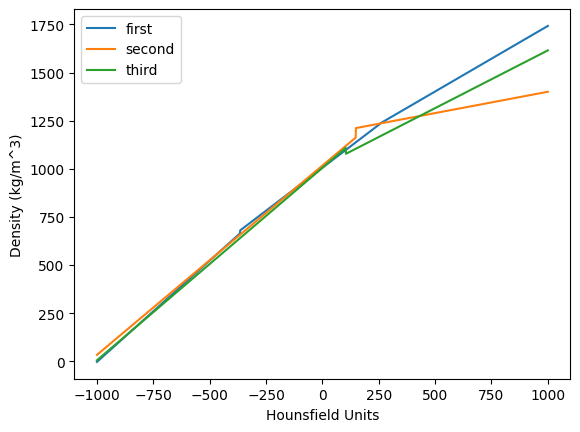

In [39]:
plt.plot(np.linspace(-1000,1000,2000), transfer_function(np.linspace(-1000,1000,2000), method='first'))
plt.plot(np.linspace(-1000,1000,2000), transfer_function(np.linspace(-1000,1000,2000), method='second'))
plt.plot(np.linspace(-1000,1000,2000), transfer_function(np.linspace(-1000,1000,2000), method='third'))
plt.xlabel('Hounsfield Units')
plt.ylabel('Density (kg/m^3)')
plt.legend(['first', 'second', 'third'])

In [41]:
test_phantom = phantom.Phantom(source_path = None,
                               voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
                               matrix_dims = (300,300,300),
                               baseline = (1540, 1000),
                               seed = 5678,
                               )

In [42]:
test_phantom.create_from_image(image, voxel_size, transfer_fn=functools.partial(transfer_function, method='first'), )

In [43]:
test_phantom.get_complete().shape

(2, 362, 362, 254)

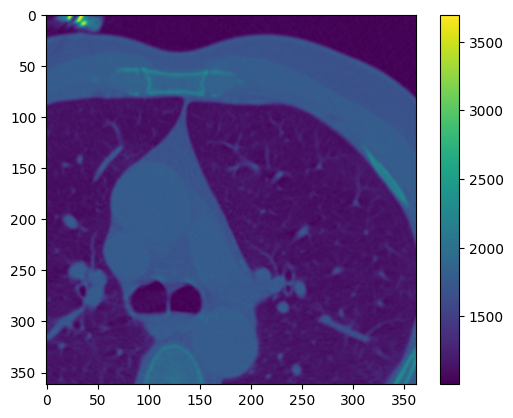

In [44]:
plt.imshow(test_phantom.get_complete()[1][:,:,0])
plt.colorbar()

In [45]:
test_phantom.get_complete()

array([[[[1581.134016  , 1590.063937  , 1598.993858  , ...,
          2825.833472  , 2825.833472  , 2834.751689  ],
         [1580.66342093, 1586.34471788, 1592.02601484, ...,
          2818.69194236, 2808.68684484, 2814.72700221],
         [1587.29729339, 1585.942435  , 1584.58757661, ...,
          2835.29368009, 2827.66522798, 2830.55777935],
         ...,
         [1612.47412973, 1615.07378799, 1617.67344625, ...,
          1588.06011282, 1592.20059043, 1591.86661973],
         [1619.56341678, 1621.48754341, 1623.41167003, ...,
          1596.63708752, 1601.54417968, 1603.82125261],
         [1604.68654032, 1600.6143749 , 1596.54220948, ...,
          1601.55556504, 1603.21403316, 1603.21403316]],

        [[1620.23135818, 1628.92598164, 1637.6206051 , ...,
          2839.33107894, 2842.69606105, 2845.76831   ],
         [1611.84879435, 1617.46148557, 1623.07417679, ...,
          2810.9994864 , 2807.6345043 , 2813.94488058],
         [1594.00056836, 1593.68674745, 1593.37292654, .

In [46]:
utils.save_mrc(test_phantom.get_complete(), '../experiment_files/images/Patient_10/phantom_5e-4.mrc')

test_phantom.save('../experiment_files/cardiac_phantom')

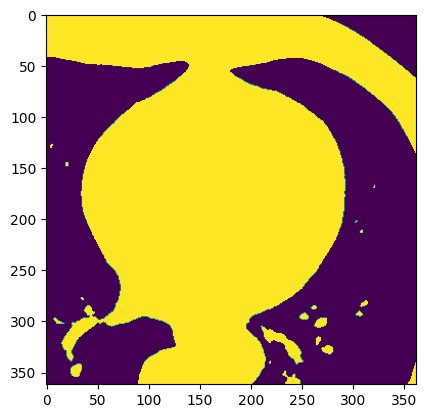

In [17]:
plt.imshow(np.where(test_phantom.get_complete()[1][:,:,127] > 1600, 1, 0))

In [23]:
array_2_mesh = np.where(test_phantom.get_complete()[1] > 1600, 1, 0)

In [21]:
import mcubes

In [29]:

# Marching cubes without smoothing
vertices_unsmooth, triangles_unsmooth = mcubes.marching_cubes(array_2_mesh, 0.5)
mcubes.export_obj(vertices, triangles, 'heartCT.obj')

# # Marching cubes with smoothing
# smoothed_heartCT = mcubes.smooth(array_2_mesh)
# vertices, triangles = mcubes.marching_cubes(smoothed_heartCT, 0)
# mcubes.export_obj(vertices, triangles, 'smooth_heartCT.obj')

In [15]:
# Create a data volume (30 x 30 x 30)
X, Y, Z = np.mgrid[:30, :30, :30]
u = (X-15)**2 + (Y-15)**2 + (Z-15)**2 - 8**2

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(u, 0.5)

# Export the result to sphere.obj
# mcubes.export_obj(vertices, triangles, 'sphere.obj')

In [16]:
x, y, z = np.mgrid[:100, :100, :100]
binary_sphere = ((x - 50)**2 + (y - 50)**2 + (z - 50)**2 - 25**2 < 0) + ((x - 35)**2 + (y - 43)**2 + (z - 77)**2 - 20**2 < 0) + ((x - 75)**2 + (y - 35)**2 + (z - 75)**2 - 15**2 < 0) > 0

# Extract the 0.5-levelset since the array is binary
vertices, triangles = mcubes.marching_cubes(binary_sphere, 0.5)

mcubes.export_obj(vertices, triangles, 'sphere_rough.obj')

In [17]:
smoothed_sphere = mcubes.smooth(binary_sphere)

# Extract the 0-levelset (the 0-levelset of the output of mcubes.smooth is the
# smoothed version of the 0.5-levelset of the binary array).
vertices, triangles = mcubes.marching_cubes(smoothed_sphere, 0)

mcubes.export_obj(vertices, triangles, 'sphere_smooth.obj')